## Parte 1 - Alinhar os grãos horizontalmente 

Primeiramente, será importado as bibliotecas que serão utilizadas durante o programa

In [1]:
import pandas as pd
import numpy as np
import cv2
import math
import sys
import keras
import matplotlib.pyplot as plt

A primeira etapa tem como objetivo alinhar os grãos horizontalmente, para isso, será necessário encontrar o centro de massa e a orientação das imagens do dataset. Para isso ser possível, será utilizada a função findCenterAndOrientation()

In [2]:
def findCenterAndOrientation(src):
    M = cv2.moments(src)
    cen_x = 0.0  # Valor padrão para cen_x
    cen_y = 0.0  # Valor padrão para cen_y
    if M["m00"] != 0:
        cen_x = M["m10"] / M["m00"]
        cen_y = M["m01"] / M["m00"]
    theta = 0.5 * math.atan2(2 * M["mu11"], M["mu20"] - M["mu02"])

    return cen_x, cen_y, theta

Para saber se a função findCenterAndOrientation() está funcionando adequadamente e sendo possível rotacionar a imagem, vamos testar com a imagem "Jasmine (2).jpg", uma das imagens do DataSet. Primeramente, vamos ler a imagem e colocar em img.

In [3]:
img = cv2.imread('Jasmine (2).jpg', 0)

Vamos observar como a imagem é antes de ser rotacionada.

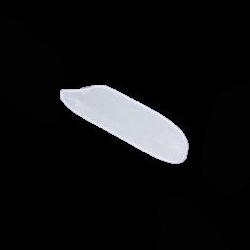

In [4]:
from IPython.display import Image

Image(filename='Jasmine (2).jpg')

Utilizando a função findCenterAndOrientation() nessa imagem, vamos obter os pontos x, y e o ângulo da orientação.

In [5]:
x, y, theta = findCenterAndOrientation(img)
ponto = (x,y)

Para realizar a rotação, vamos utilizar o OpenCV, o método getRotationMatrix2D() e warpAffine(). Como o parâmetro do ângulo para o getRotationMatrix2D() está em graus e a nossa função retorna o valor em radianos, vamos converter o ângulo com a equação básica: $\theta(^o) = 180 \cdot \frac{\theta(rad)}{\pi}$

In [6]:
angulo = 180*theta/math.pi
rotacao = cv2.getRotationMatrix2D(ponto, angulo, 1.0)
rotacionado = cv2.warpAffine(img, rotacao, (len(img[0]), len(img[1])))

Com isso, temos a imagem rotacionada na variável rotacionado. Agora, para podermos visualizar o resultado, vamos passar os valores para uma imagem .png.

In [7]:
cv2.imwrite('rice_1to50/Jasmine/Jasmine (2).png',rotacionado)

True

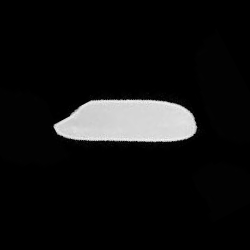

In [8]:
Image(filename='rice_1to50/Jasmine/Jasmine (2).png') 

Com isso, temos a imagem Jasmine (2).jpg alinhada horizontalmente. Agora, será necessário realizar esse procidimento em todas as imagens.

Como as imagens estão escritas como: "nome_do_grão (i).jpg", será criado um array com os nomes dos tipos de grãos que será percorrido por um loop for e dentro desse loop, terá um outro loop para ir de 1 a 1000, conseguindo percorrer todas as imagens. Cada imagem lida será rotacionada, como o procedimento realizado anteriormente, e escrita para uma imagem com o padrão "nome_do_grão (i).png".

In [9]:
rices = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

for rice in rices:
    for num in range(1,51):
        img = cv2.imread(rice + ' ({}).jpg'.format(num), 0)
        if img is not None:
            x, y, theta = findCenterAndOrientation(img)
            ponto = (x,y)
            angulo = 180*theta/math.pi
            rotacao = cv2.getRotationMatrix2D(ponto, angulo, 1.0)
            rotacionado = cv2.warpAffine(img, rotacao, (len(img[0]), len(img[1])))
            cv2.imwrite(rice + ' ({}).png'.format(num),rotacionado)
        else:
            print("Erro ao ler a imagem:", rice + ' ({}).jpg'.format(num))

## Parte 2 - Classificar as imagens não-alinhadas e alinhadas

Primeiramente, vamos criar uma função para ler a quantidade de imagens que desejamos e se serão as imagens alinhadas ou desalinhadas.

In [10]:
def le(diretorio, nl, nc, inic, fim, alinhada=True):
    nclasses = len(diretorio)
    n = nclasses * (fim - inic + 1)
    AX = np.empty((n, nl, nc), np.uint8)
    AY = np.empty((n,), np.uint8)
    j = 0
    k = 0
    for nome in diretorio:
        for i in range(inic, fim + 1):
            if alinhada == True:
                st = nome + ' ({}).png'.format(i)
            else:
                st = nome + ' ({}).jpg'.format(i)
            a = cv2.imread(st, 0)
            if a is None:
                print("Erro leitura", st)
                sys.exit()
            a = cv2.resize(a, (nl, nc), interpolation=cv2.INTER_AREA)
            AX[k, :, :] = a
            AY[k] = j
            k += 1
        j += 1
    return AX, AY

Vamos criar um AX e um AY para cada caso e aplicar na nossa rede que será criada posteriormente. Note que cada caso em "na", que guarda os valores das duplas de interesse para este exercício: intervalos de 1-10, 11-20, 21-30, 31-40, 41-50.


In [11]:
diretorio = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]
nl = 28
nc = 28
na = [(1, 10), (11, 20), (21, 30), (31, 40), (41, 50)]
nclasses = len(diretorio)

AX_1_10_a, AY_1_10_a = le(diretorio,nl,nc, 1,na[0][0], alinhada=True)
AX_11_20_a, AY_11_20_a = le(diretorio,nl,nc, 1,na[1][0], alinhada=True)
AX_21_30_a, AY_21_30_a = le(diretorio,nl,nc, 1,na[2][0], alinhada=True)
AX_31_40_a, AY_31_40_a = le(diretorio,nl,nc, 1,na[3][0], alinhada=True)
AX_41_50_a, AY_41_50_a = le(diretorio,nl,nc, 1,na[4][0], alinhada=True)

AX_1_10_d, AY_1_10_d = le(diretorio,nl,nc, 1,na[0][0], alinhada=False)
AX_11_20_d, AY_11_20_d = le(diretorio,nl,nc, 1,na[1][0], alinhada=False)
AX_21_30_d, AY_21_30_d = le(diretorio,nl,nc, 1,na[2][0], alinhada=False)
AX_31_40_d, AY_31_40_d = le(diretorio,nl,nc, 1,na[3][0], alinhada=False)
AX_41_50_d, AY_41_50_d = le(diretorio,nl,nc, 1,na[4][0], alinhada=False)

AY_1_10_a = keras.utils.to_categorical(AY_1_10_a, nclasses)
AY_11_20_a = keras.utils.to_categorical(AY_11_20_a, nclasses)
AY_21_30_a = keras.utils.to_categorical(AY_21_30_a, nclasses)
AY_31_40_a = keras.utils.to_categorical(AY_31_40_a, nclasses)
AY_41_50_a = keras.utils.to_categorical(AY_41_50_a, nclasses)

AY_1_10_d = keras.utils.to_categorical(AY_1_10_d, nclasses)
AY_11_20_d = keras.utils.to_categorical(AY_11_20_d, nclasses)
AY_21_30_d = keras.utils.to_categorical(AY_21_30_d, nclasses)
AY_31_40_d = keras.utils.to_categorical(AY_31_40_d, nclasses)
AY_41_50_d = keras.utils.to_categorical(AY_41_50_d, nclasses)


Por fim, vamos definir o QX e QY para testar a rede treinada, com as 50 imagens de cada tipo de arroz.

In [12]:
QX, QY = le(diretorio, nl, nc, 1, 50)

nclasses = max(nclasses, max(QY)) 

QY2 = keras.utils.to_categorical(QY, nclasses)

A rede criada conterá as duas primeiras camadas como camadas convolucionais e as duas últimas como camadas densas. 

In [13]:
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras import optimizers
import numpy as np; import sys; import os; from time import time

def NN(AX, AY):
    model = Sequential() # 28x28
    model.add(Conv2D(20, kernel_size=(5,5), activation='relu', input_shape=(nl, nc, 1) )) #20x24x24
    model.add(MaxPooling2D(pool_size=(2,2))) #20x12x12
    model.add(Conv2D(40, kernel_size=(5,5), activation='relu')) #40x8x8
    model.add(MaxPooling2D(pool_size=(2,2))) #40x4x4
    model.add(Flatten()) #640
    model.add(Dense(200, activation='relu')) #200
    model.add(Dense(nclasses, activation='softmax')) #10

    from tensorflow.keras.utils import plot_model
    model.summary()
    opt=optimizers.Adam()
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    t0=time()
    history = model.fit(AX, AY, batch_size=100, epochs=30, verbose=1)
    score = model.evaluate(QX, QY2, verbose=False)
    print('\nTest loss: %.4f'%(score[0]))
    print('Test accuracy: %.2f %%'%(100*score[1]))
    print('Test error: %.2f %%'%(100*(1-score[1])))
    t2=time()
    QP2=model.predict(QX); QP=np.argmax(QP2,1)
    t3=time(); print("Tempo de predicao: %.2f s"%(t3-t2))
    nerro=np.count_nonzero(QP-QY); print("nerro=%d"%(nerro))
    return history

Para realizar os treinamentos e os testes, vamos realizar na seguinte sequência: testar cada caso alinhado e depois cada caso desalinhado. Além disso, vamos gerar um gráfico com o valor das perdas em cada época.

Intervalo de 1-10 - alinhado: Dados

In [14]:
history_1 = NN(AX_1_10_a, AY_1_10_a)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 20)        520       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 20)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 40)          20040     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 40)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 640)               0         
                                                                 
 dense (Dense)               (None, 200)               1

Intervalo de 1-10 - alinhado: Gráfico

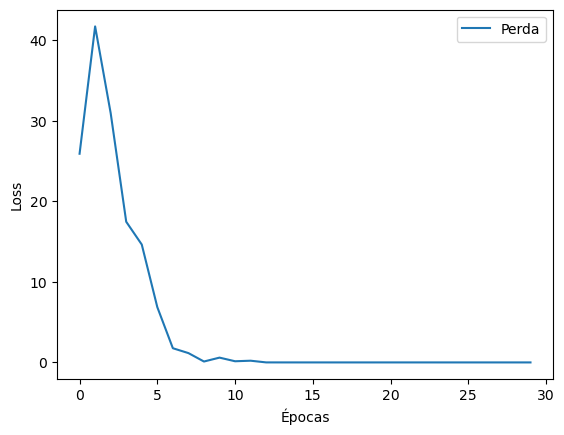

In [15]:
plt.plot(history_1.history['loss'], label='Perda')
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.show()

Intervalo de 1-10 - desalinhado: Dados

In [16]:
history_1 = NN(AX_1_10_d, AY_1_10_d)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 24, 24, 20)        520       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 20)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 40)          20040     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 40)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 640)               0         
                                                                 
 dense_2 (Dense)             (None, 200)              

Intervalo de 1-10 - desalinhado: Gráfico

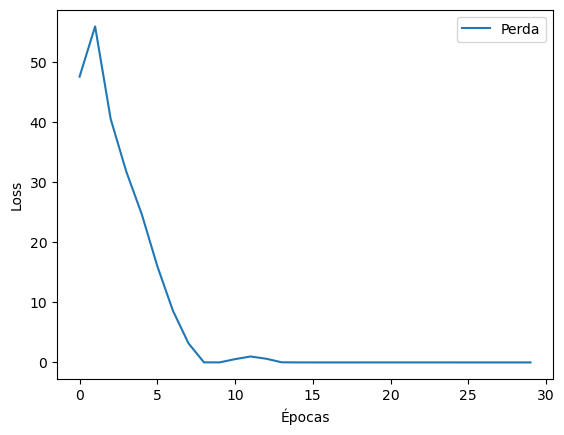

In [17]:
plt.plot(history_1.history['loss'], label='Perda')
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.show()

Intervalo de 11-20 - alinhado: Dados

In [18]:
history_1 = NN(AX_11_20_a, AY_11_20_a)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 24, 24, 20)        520       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 20)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 40)          20040     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 40)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 640)               0         
                                                                 
 dense_4 (Dense)             (None, 200)              

Gráfico - Intervalo de 11-20 - alinhado: Gráfico

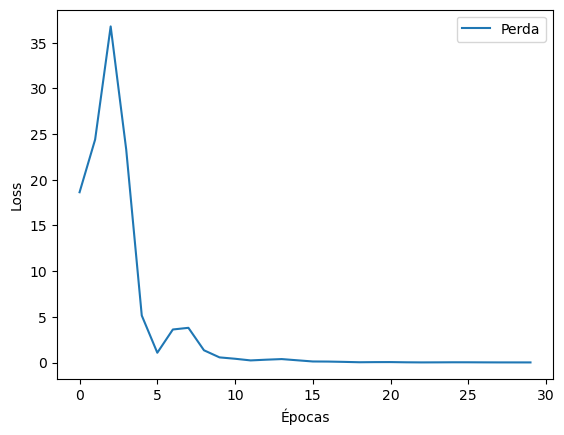

In [19]:
plt.plot(history_1.history['loss'], label='Perda')
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.show()

Intervalo de 11-20 - desalinhado: Dados

In [20]:
history_1 = NN(AX_11_20_d, AY_11_20_d)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 24, 24, 20)        520       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 12, 12, 20)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 40)          20040     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 4, 4, 40)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 640)               0         
                                                                 
 dense_6 (Dense)             (None, 200)              

Gráfico - Intervalo de 11-20 - desalinhado: Gráfico

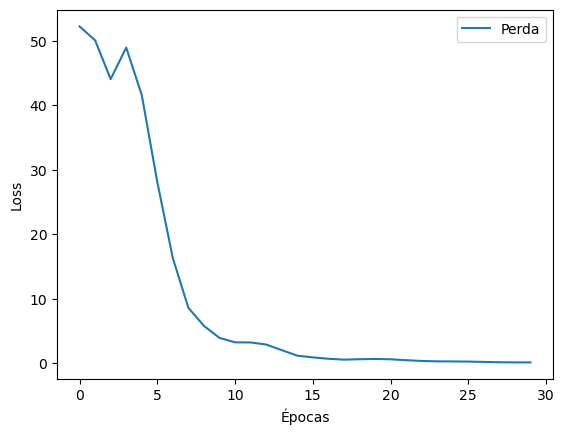

In [21]:
plt.plot(history_1.history['loss'], label='Perda')
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.show()

Intervalo de 21-30 - alinhado: Dados

In [22]:
history_1 = NN(AX_21_30_a, AY_21_30_a)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 24, 24, 20)        520       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 12, 12, 20)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 40)          20040     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 4, 4, 40)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 640)               0         
                                                                 
 dense_8 (Dense)             (None, 200)              

Intervalo de 21-30 - alinhado: Gráfico

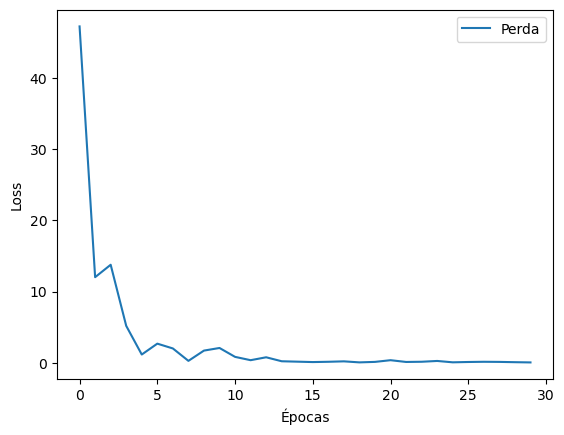

In [23]:
plt.plot(history_1.history['loss'], label='Perda')
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.show()

Intervalo de 21-30 (desalinhado): Dados

In [24]:
history_1 = NN(AX_21_30_d, AY_21_30_d)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 24, 24, 20)        520       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 12, 12, 20)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 40)          20040     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 4, 4, 40)         0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 640)               0         
                                                                 
 dense_10 (Dense)            (None, 200)              

Gráfico - Intervalo de 21-30 - desalinhado: Gráfico

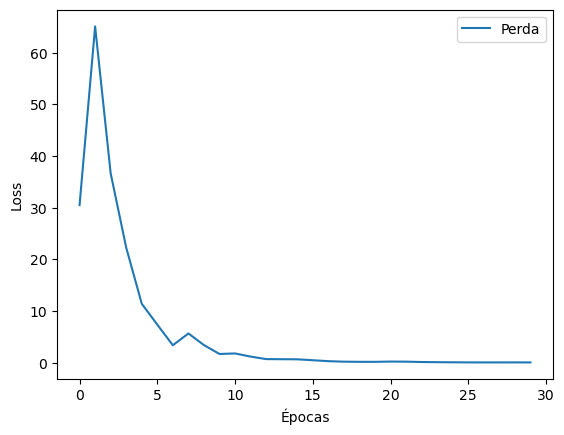

In [25]:
plt.plot(history_1.history['loss'], label='Perda')
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.show()

Intervalo de 31-40 - alinhado: Dados

In [26]:
history_1 = NN(AX_31_40_a, AY_31_40_a)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 24, 24, 20)        520       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 12, 12, 20)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 8, 8, 40)          20040     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 4, 4, 40)         0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 640)               0         
                                                                 
 dense_12 (Dense)            (None, 200)              

Gráfico - Intervalo de 31-40 - alinhado

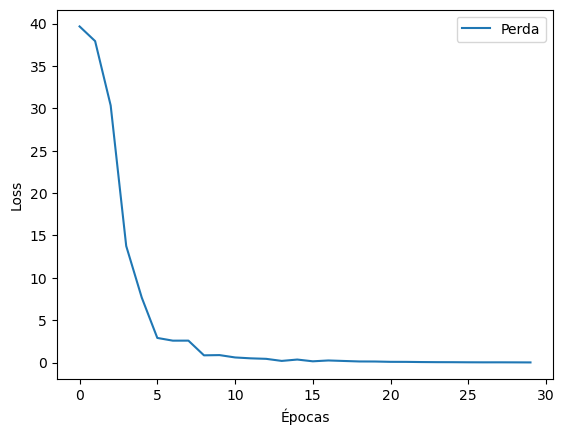

In [27]:
plt.plot(history_1.history['loss'], label='Perda')
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.show()

Intervalo de 31-40 - desalinhado: Dados

In [28]:
history_1 = NN(AX_31_40_d, AY_31_40_d)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 24, 24, 20)        520       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 12, 12, 20)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 8, 8, 40)          20040     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 4, 4, 40)         0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 640)               0         
                                                                 
 dense_14 (Dense)            (None, 200)              

Gráfico - Intervalo de 31-40 - desalinhado

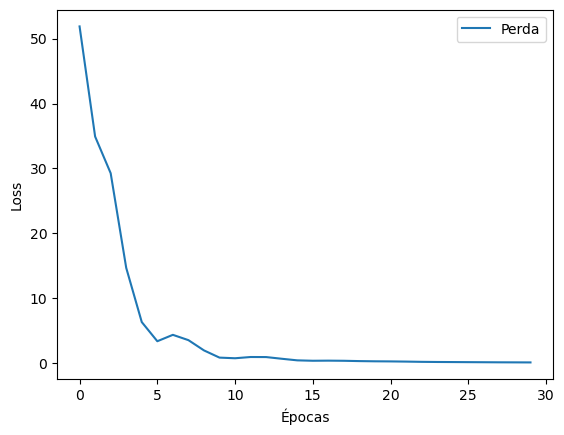

In [29]:
plt.plot(history_1.history['loss'], label='Perda')
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.show()

Intervalo de 41-50 - alinhado: Dados

In [30]:
history_1 = NN(AX_41_50_a, AY_41_50_a)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 24, 24, 20)        520       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 12, 12, 20)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 8, 8, 40)          20040     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 4, 4, 40)         0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 640)               0         
                                                                 
 dense_16 (Dense)            (None, 200)              

Gráfico - Intervalo de 41-50 - alinhado

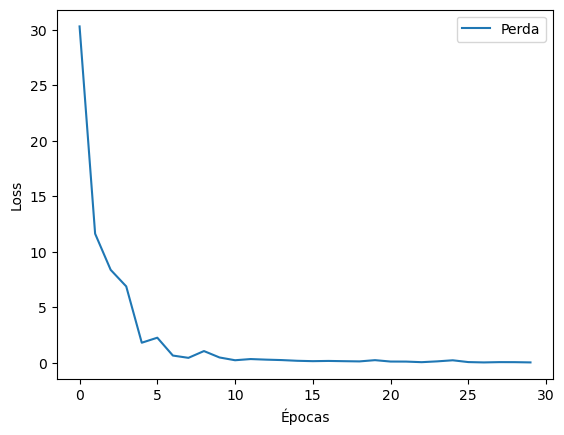

In [31]:
plt.plot(history_1.history['loss'], label='Perda')
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.show()

Intervalo de 41-50 - desalinhado: Dados

In [32]:
history_1 = NN(AX_41_50_d, AY_41_50_d)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 24, 24, 20)        520       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 12, 12, 20)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 8, 8, 40)          20040     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 4, 4, 40)         0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 640)               0         
                                                                 
 dense_18 (Dense)            (None, 200)              

Gráfico - Intervalo de 41-50 - desalinhado

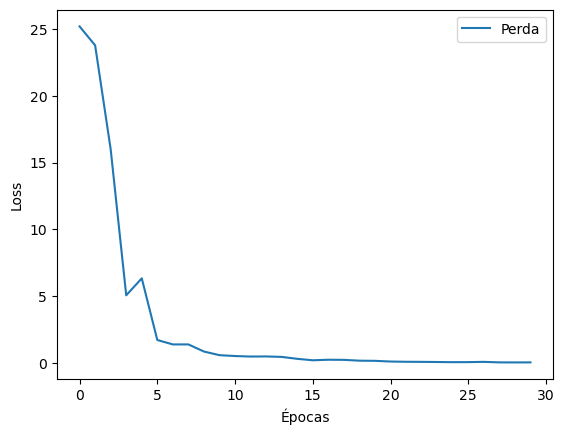

In [33]:
plt.plot(history_1.history['loss'], label='Perda')
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.show()

Colocando os valores da acurácia dos testes em uma tabela para ser possível observar ao todo os resultados.

$n_a$   | Alinhado  | Desalinhado
--------- | ----------- |----------    
1-10  | 62,00%      |  44,40% 
11-20 | 92,40%      |  71,60%
21-30 | 95,60%      |  90,00%
31-40 | 98,80%      |  92,40%
41-50 | 98,80%      |  84,80%

Como podemos observar, foi possível obter uma acurácia bem maior com as imagens alinhadas horizontalmente em comparação com as imagens diretas do dataset.